# Transfer Learning with Tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn a new kind of tranfer learning: fine-tuning.

In [2]:
import tensorflow as tf
!nvidia-smi
tf.config.list_physical_devices
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
!python --version


Sat Mar  8 23:29:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:09:00.0  On |                  N/A |
|  0%   34C    P8              4W /  320W |     923MiB /  16376MiB |     37%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating helper function
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Always a good idea to use helper functions remember the don't repeat yourself rule

In [3]:
!apt-get install wget
!pip install scikit-learn
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  wget
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 348 kB of archives.
After this operation, 1012 kB of additional disk space will be used.
Err:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 wget amd64 1.20.3-1ubuntu2
  404  Not Found [IP: 91.189.91.81 80]
E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/main/w/wget/wget_1.20.3-1ubuntu2_amd64.deb  404  Not Found [IP: 91.189.91.81 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
     |████████████████████████████████| 11.1 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 19.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
/usr/bin/sh: 1: wget: not foun

In [83]:
# Import helper functions we're going to use in the notebook
from helper_functions import *


> **Note** if you're running this notebook in Colab, the runtime may time out.  When the runtime runs out colab will delete the helper function so will need to redownload.

## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [5]:
# Get 10% of training data of 10 classes of Food101
if(not os.path.exists("10_food_classes_10_percent.zip")):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Checkout how many images and sub directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [7]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[2.53801025e+02 2.53341827e+02 1.65872452e+02]
   [2.50974487e+02 2.50663254e+02 1.57836731e+02]
   [2.52561218e+02 2.52581635e+02 1.55357147e+02]
   ...
   [2.54000000e+02 2.54000000e+02 1.80989761e+02]
   [2.54000000e+02 2.55000000e+02 1.76806091e+02]
   [2.54000000e+02 2.55000000e+02 1.72642822e+02]]

  [[2.50505096e+02 2.38025497e+02 1.43045914e+02]
   [2.47367340e+02 2.35795914e+02 1.36224472e+02]
   [2.53418365e+02 2.40943878e+02 1.38704086e+02]
   ...
   [2.53000000e+02 2.54000000e+02 1.74285706e+02]
   [2.53000000e+02 2.54000000e+02 1.74000000e+02]
   [2.53000000e+02 2.55000000e+02 1.72000000e+02]]

  [[2.49153061e+02 2.25862244e+02 1.23234695e+02]
   [2.44244888e+02 2.18816315e+02 1.15500000e+02]
   [2.45020416e+02 2.20331635e+02 1.14117348e+02]
   ...
   [2.52785721e+02 2.55000000e+02 1.67500046e+02]
   [2.52785721e+02 2.54785721e+02 1.71586731e+02]
   [2.52785721e+02 2.53785721e+02 1.73938797e+02]]

  ...

  [[1.47729507e+02 6.84488831e+01 1.89787483e+00]
   [1

## Model 0: building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility in desiging our models

In [12]:
# Create base model
efficentnet_b0 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    classes=10,
    classifier_activation='softmax',
)

efficentnet_b0.trainable = False

# create inputs for model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# normalize, needed for some architectures
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = efficentnet_b0(inputs)
print(f"Shape after passing inputs through the base model:{x.shape}")
# average pool the outputs of base model(aggregate most important information, reduce computational expenses)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
# combine inputs and outputs into model
model_0 = tf.keras.Model(inputs,
                   outputs)

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=["accuracy"])
history_model_0 = model_0.fit(train_data_10_percent,epochs=5,validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer learning",experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 1s 0us/step
Shape after passing inputs through the base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20250308-232919
Epoch 1/5
24/24 [==============================] - 10s 87ms/step - loss: 1.9072 - accuracy: 0.4080 - val_loss: 1.3546 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 1s 37ms/step - loss: 1.1767 - accuracy: 0.7253 - val_loss: 0.9175 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 1s 40ms/step - loss: 0.8643 - accuracy: 0.8120 - val_loss: 0.7315 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 1s 40ms/step - loss: 0.6955 - accuracy: 0.8453 - val_loss: 0.6233 - val_accuracy: 0.8783
Epoch 5/5
24/24 [==============================] - 1s 38ms/step - loss: 0.6026 - accuracy: 0.8640 - val_loss: 0.5777 - val_accuracy: 0.8684


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 20ms/step - loss: 0.5712 - accuracy: 0.8608


[0.5712499618530273, 0.86080002784729]

In [14]:
# check the layers in our base model
for layer_number, layer in enumerate(efficentnet_b0.layers):
    print(f"Layer number:{layer_number} layer name:{layer.name}") 

Layer number:0 layer name:input_1
Layer number:1 layer name:rescaling
Layer number:2 layer name:normalization
Layer number:3 layer name:stem_conv
Layer number:4 layer name:stem_bn
Layer number:5 layer name:stem_activation
Layer number:6 layer name:block1a_project_conv
Layer number:7 layer name:block1a_project_bn
Layer number:8 layer name:block1a_project_activation
Layer number:9 layer name:block2a_expand_conv
Layer number:10 layer name:block2a_expand_bn
Layer number:11 layer name:block2a_expand_activation
Layer number:12 layer name:block2a_project_conv
Layer number:13 layer name:block2a_project_bn
Layer number:14 layer name:block2b_expand_conv
Layer number:15 layer name:block2b_expand_bn
Layer number:16 layer name:block2b_expand_activation
Layer number:17 layer name:block2b_project_conv
Layer number:18 layer name:block2b_project_bn
Layer number:19 layer name:block2b_drop
Layer number:20 layer name:block2b_add
Layer number:21 layer name:block3a_expand_conv
Layer number:22 layer name:blo

In [15]:
# summary of base model
efficentnet_b0.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   768        ['block3b_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block3b_project_conv (Conv2D)  (None, None, None,   9216        ['block3b_expand_activation[0][0]
                                48)                              ']                               
                                                                                                  
 block3b_p

                                384)                              'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, None, None,   36864       ['block4b_se_excite[0][0]']      
                                96)                                                               
                                                                                                  
 block4b_project_bn (BatchNorma  (None, None, None,   384        ['block4b_project_conv[0][0]']   
 lization)                      96)                                                               
                                                                                                  
 block4b_drop (Dropout)         (None, None, None,   0           ['block4b_project_bn[0][0]']     
                                96)                                                               
          

 block5a_se_excite (Multiply)   (None, None, None,   0           ['block5a_activation[0][0]',     
                                576)                              'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, None, None,   64512       ['block5a_se_excite[0][0]']      
                                112)                                                              
                                                                                                  
 block5a_project_bn (BatchNorma  (None, None, None,   448        ['block5a_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, None, None,   75264       ['block5a_project_bn[0][0]']     
          

                                                                                                  
 block5c_project_bn (BatchNorma  (None, None, None,   448        ['block5c_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5c_drop (Dropout)         (None, None, None,   0           ['block5c_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5c_add (Add)              (None, None, None,   0           ['block5c_drop[0][0]',           
                                112)                              'block5b_add[0][0]']            
                                                                                                  
 block5d_e

                                112)                                                              
                                                                                                  
 block5e_project_bn (BatchNorma  (None, None, None,   448        ['block5e_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5e_drop (Dropout)         (None, None, None,   0           ['block5e_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5e_add (Add)              (None, None, None,   0           ['block5e_drop[0][0]',           
                                112)                              'block5d_add[0][0]']            
          

 block6b_drop (Dropout)         (None, None, None,   0           ['block6b_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6b_add (Add)              (None, None, None,   0           ['block6b_drop[0][0]',           
                                192)                              'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, None, None,   221184      ['block6b_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, None, None,   4608       ['block6c_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block6d_drop (Dropout)         (None, None, None,   0           ['block6d_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6d_add (Add)              (None, None, None,   0           ['block6d_drop[0][0]',           
                                192)                              'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, None, None,   221184      ['block6d_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6e_e

 lization)                      192)                                                              
                                                                                                  
 block6f_drop (Dropout)         (None, None, None,   0           ['block6f_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6f_add (Add)              (None, None, None,   0           ['block6f_drop[0][0]',           
                                192)                              'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, None, None,   221184      ['block6f_add[0][0]']            
                                1152)                                                             
          

 block6h_project_bn (BatchNorma  (None, None, None,   768        ['block6h_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block6h_drop (Dropout)         (None, None, None,   0           ['block6h_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6h_add (Add)              (None, None, None,   0           ['block6h_drop[0][0]',           
                                192)                              'block6g_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   245760      ['block6h_add[0][0]']            
          

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


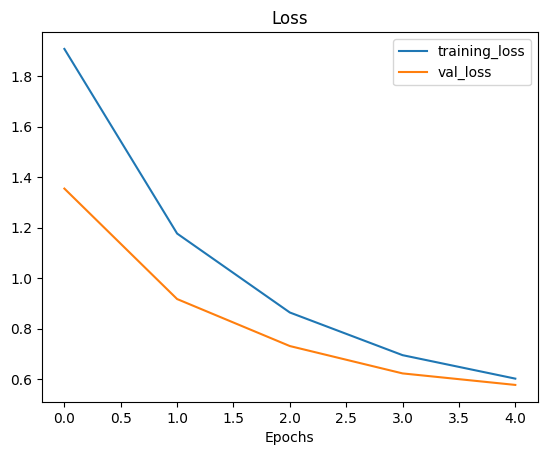

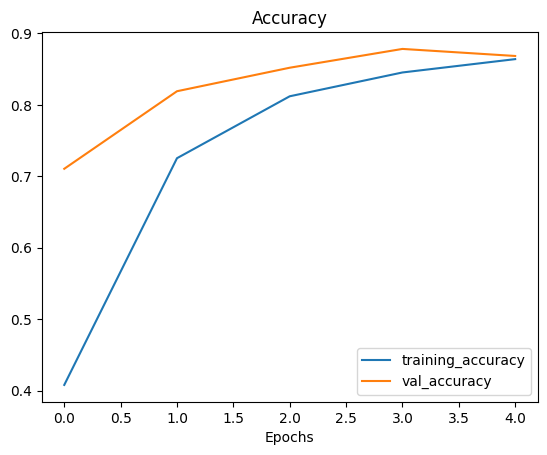

In [93]:
# Check out models training curves
plt.show(plot_loss_curves(history_model_0))

## Getting a feature vector from a trained model 
Let's demonstrate the Global Average Pooling 2d layer...
We have a tensor after our model goes through `base+model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [18]:
# define input shape
input_shape =(1,4,4,3)
#create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a random global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D: {global_average_pooled_tensor}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

**Note** Onen of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector - a learned representation of the input data.

In [20]:
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor) 
print(global_max_pool_tensor)

tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with only 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning iwth 1% of the training data with augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data which will also use data augmentation
4. `model_4`- use fine-tuning transfer learning on 100% of the training data with data augmentation.
   
**Note**: throughout all experiments we will use the same test dataset, so that we can be consistent in evaluation

## Getting and preprocessing data for model 1

In [31]:
# Download and unzip data
 
if not os.path.exists("./10_food_classes_1_percent.zip"):
    !curl --output "10_food_classes_1_percent.zip" -X GET "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
    unzip_data("./10_food_classes_1_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127M  100  127M    0     0  22.4M      0  0:00:05  0:00:05 --:--:-- 26.2M


In [32]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [33]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [34]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model


To add data augmentation right into our models, we can use the layers inside:

+ `tf.keras.layers.experimental.preprocessing()`

Benefits of data augmentation

+ More data - model may be better able to generalize
+ preprocessing of images(augmenting them) happens on the GPU which is far faster for this type of problem than the CPU
+ Image data augmentation only happens during training so we can still export out model and use it elsewhere.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms,etc.
    
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescaling(1./255) - keep for models like resnet50V2 but for efficientnet it has rescaling built in
],name="data_augmentation")

### visualize our data augmentation layer(and check the data)

In [39]:
# View a random image and compare it to the augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(target_dir)
# read in random image + plot
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)
# now let's plot augmented random image
augmented_image = data_augmentation(img)
plt.figure()
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_image / 255.))
print(img)
print(random_image)

10_food_classes_1_percent/train/fried_rice
[[[213 233 255]
  [212 232 255]
  [211 231 255]
  ...
  [247 255 253]
  [246 255 252]
  [246 255 252]]

 [[208 228 252]
  [207 227 251]
  [206 226 250]
  ...
  [247 255 253]
  [246 255 252]
  [246 255 252]]

 [[203 221 245]
  [202 220 244]
  [202 220 244]
  ...
  [246 255 254]
  [245 255 254]
  [244 254 253]]

 ...

 [[173 182 199]
  [174 183 200]
  [172 181 198]
  ...
  [ 86  71  74]
  [ 88  72  75]
  [ 87  71  74]]

 [[180 187 205]
  [179 186 204]
  [177 184 202]
  ...
  [ 91  76  81]
  [ 92  76  79]
  [ 92  76  79]]

 [[186 193 211]
  [184 191 209]
  [180 187 205]
  ...
  [ 92  77  82]
  [ 93  77  80]
  [ 92  76  79]]]
2980189.jpg


## Model 1: Feature extraction on transfer learning on 1% of the data using data augmentation

In [68]:
# Setup input shape and base model freezing the base model layers
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Crete input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# GIve base_model the inputs(after augmentation) & don't train it

x = base_model(x,training=False)

# Pool output features of the base model

x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="ouput_layer")(x)

# Make a model using inputs and outpus

model_1 = keras.Model(inputs,outputs)

# compile the model

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250309-003751
Epoch 1/5
3/3 [==============================] - 7s 742ms/step - loss: 2.4530 - accuracy: 0.0857 - val_loss: 2.3752 - val_accuracy: 0.1036
Epoch 2/5
3/3 [==============================] - 1s 302ms/step - loss: 2.1222 - accuracy: 0.1714 - val_loss: 2.2407 - val_accuracy: 0.1579
Epoch 3/5
3/3 [==============================] - 1s 304ms/step - loss: 1.9245 - accuracy: 0.4857 - val_loss: 2.1170 - val_accuracy: 0.2352
Epoch 4/5
3/3 [==============================] - 1s 291ms/step - loss: 1.7405 - accuracy: 0.6286 - val_loss: 1.9989 - val_accuracy: 0.3339
Epoch 5/5
3/3 [==============================] - 1s 305ms/step - loss: 1.6302 - accuracy: 0.7000 - val_loss: 1.9054 - val_accuracy: 0.3849


In [69]:
# Checkout model 1 summary
model_1.summary()
history_1_percent.history

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 512, 3)           0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

{'loss': [2.452963352203369,
  2.122196674346924,
  1.924500584602356,
  1.7404987812042236,
  1.6302003860473633],
 'accuracy': [0.08571428805589676,
  0.17142857611179352,
  0.48571428656578064,
  0.6285714507102966,
  0.699999988079071],
 'val_loss': [2.3752384185791016,
  2.2406771183013916,
  2.1169960498809814,
  1.9989491701126099,
  1.9054332971572876],
 'val_accuracy': [0.10361842066049576,
  0.15789473056793213,
  0.23519736528396606,
  0.33388158679008484,
  0.38486841320991516]}

In [70]:
# Evaluate on full data set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 2s 24ms/step - loss: 1.8849 - accuracy: 0.4024


[1.884901762008667, 0.4023999869823456]

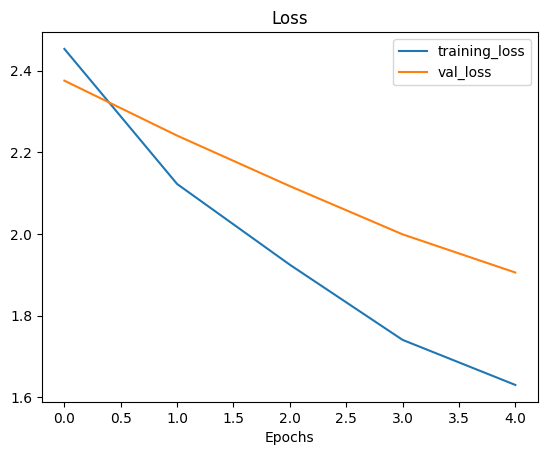

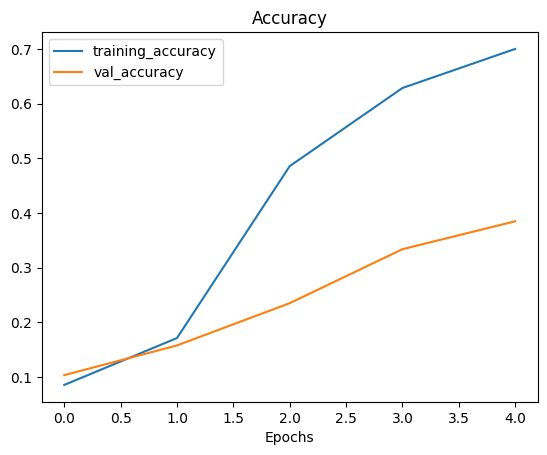

In [92]:
# Plot loss curves for data augmentation with 1 percent
plt.show(plot_loss_curves(history_1_percent))
